<a href="https://colab.research.google.com/github/nishitgala89/ML_fromScratch/blob/main/LogisticRegression_fromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

Credit - https://madewithml.com/courses/foundations/logistic-regression/

Logistic regression is an extension on linear regression (both are generalized linear methods). We will still learn to model a line (plane) that models $y$ given $X$. Except now we are dealing with classification problems as opposed to regression problems so we'll be predicting probability distributions as opposed to a discrete value. We'll be using the softmax operation to normalize our logits ($XW$) to derive probabilities.

Our goal is to learn a logistic model $\hat{y}$ that models $y$ given $X$. 

$ \hat{y} = \frac{e^{XW_y}}{\sum_j e^{XW}} $ 
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DXC}$ ($C$ is the number of classes)

This function is known as the multinomial logistic regression or the softmax classifier. The softmax classifier will use the linear equation ($z=XW$) and normalize it (using the softmax function given by $\frac{e^{XW_y}}{\sum_j e^{XW}}$) to produce the probabiltiy for class y given the inputs.

> We'll leave the bias weights out for now to avoid complicating the backpropagation calculation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [3]:
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,14.338940,15.541530,malignant
1,14.751821,13.618972,benign
2,16.998943,15.296528,benign
3,14.936796,17.024649,malignant
4,15.613526,13.359265,benign


In [4]:
X = df[["leukocyte_count", "blood_pressure"]]
y = df["tumor_class"]

In [5]:
X.head()

,leukocyte_count,blood_pressure
0,14.338940,15.541530
1,14.751821,13.618972
2,16.998943,15.296528
3,14.936796,17.024649
4,15.613526,13.359265


In [6]:
y.head()

0    malignant
1       benign
2       benign
3    malignant
4       benign
Name: tumor_class, dtype: object

In [7]:
y.unique()

array(['malignant', 'benign'], dtype=object)

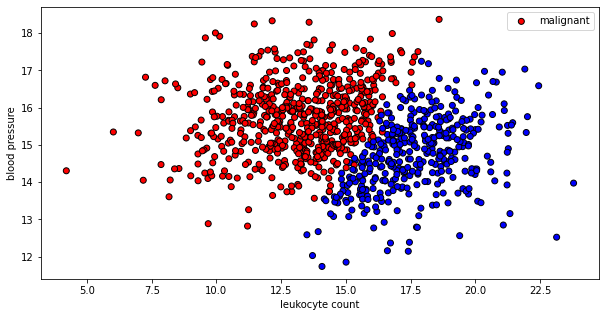

In [8]:
plt.figure(figsize=(10,5))
colors = {"benign": "blue", "malignant": "red"}
plt.scatter(x = "leukocyte_count", y = "blood_pressure", data = df, c=[colors[_y] for _y in df["tumor_class"]],  edgecolors="k", )
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(['malignant','benign']);

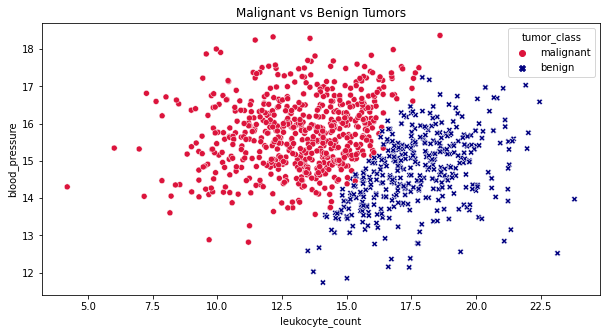

In [9]:
import seaborn as sns
plt.figure(figsize=(10,5))
# #colors = ["#FF0B04", "#4374B3"]
# colors =["red", "blue"]
# sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "leukocyte_count", y = "blood_pressure", data = df, hue= "tumor_class",alpha=1.0, palette = ['crimson','navy'], style='tumor_class');
plt.title("Malignant vs Benign Tumors");

In [10]:
TRAIN_SIZE = 0.75
TEST_SIZE = 0.25

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (750, 2), y_train: (750,)
X_test: (250, 2), y_test: (250,)


In [12]:
#print (f"Sample point: {X_train[0]} → {y_train[0]}")
X_train.head()

,leukocyte_count,blood_pressure
824,14.078463,11.736217
57,17.462393,14.818632
979,14.953989,15.274708
634,10.436035,17.136370
532,10.600758,15.444195


In [13]:
y_train.head()

824       benign
57        benign
979    malignant
634    malignant
532    malignant
Name: tumor_class, dtype: object

In [14]:
# Per data split class distribution
import collections
train_class_counts = dict(collections.Counter(y_train))

test_class_counts = dict(collections.Counter(y_test))

In [16]:
print(f' train m:b = {train_class_counts["malignant"]/ train_class_counts["benign"] : .2f}')
print (f' test m:b = {test_class_counts["malignant"]/test_class_counts["benign"]:.2f}')

 train m:b =  1.57
 test m:b = 1.58


In [17]:
y_train.head()

824       benign
57        benign
979    malignant
634    malignant
532    malignant
Name: tumor_class, dtype: object

In [18]:
le = LabelEncoder().fit(y_train)
y_train_encoded = le.transform(y_train)
y_train_encoded[:5]

array([0, 0, 1, 1, 1])

In [19]:
y_test.head()

197    malignant
731    malignant
821    malignant
809    malignant
993       benign
Name: tumor_class, dtype: object

In [20]:
y_test_encoded = le.transform(y_test)
y_test_encoded[:5]

array([1, 1, 1, 1, 0])

### Initializing Class Weights

In [21]:
# Class weights
counts = np.bincount(y_train_encoded)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")
#counts

counts: [292 458]
weights: {0: 0.003424657534246575, 1: 0.002183406113537118}


In [22]:
class_weights

{0: 0.003424657534246575, 1: 0.002183406113537118}

### Standardization of Features

In [23]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)

# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [24]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test):.1f}, std: {np.std(X_test):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test):.1f}, std: {np.std(X_test):.1f}")

X_test[0]: mean: -0.0, std: 1.0
X_test[1]: mean: -0.0, std: 1.0


##Model

### 1. Randomly initialize the model's weights $W$.

In [25]:
INPUT_DIM =X_train.shape[1] # Number of features ("leukocyte_count,"blood_pressure")
NUM_CLASSES = len(y_train.unique()) # Number of classes to be predicted ("malignant", "benign")

W = 0.005 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


### 2. Feed inputs $X$ into the model to receive the logits ($z=XW$). Apply the softmax operation on the logits to get the class probabilies $\hat{y}$ in one-hot encoded form. For example, if there are three classes, the predicted class probabilities could look like [0.3, 0.3, 0.4]. 
  * $ \hat{y} = softmax(z) = softmax(XW) = \frac{e^{XW_y}}{\sum_j e^{XW}} $
  > Note : We have bias term initialization with 0's to avoid complexity

In [26]:
X_train.shape, W.shape, b.shape

((750, 2), (2, 2), (1, 2))

In [27]:
# Forward Pass
logits = np.dot(X_train, W) + b
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (750, 2)
sample: [0.01203771 0.03495807]


#### To Understand the math

In [28]:
# tmp = np.dot(X_train, W)
# tmp[:5]

In [29]:
# b_tmp = np.ones((1, NUM_CLASSES))
# b_tmp

In [30]:
# tmp = tmp + b_tmp
# tmp[:5]

#### Deriving the Class Proabilities by applying softmax function to the logits

In [31]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[500]}")

y_hat: (750, 2)
sample: [0.50364499 0.49635501]


#### Understanding the math

In [32]:
exp_logits

array([[1.01211045, 1.03557629],
       [0.9992687 , 1.00348121],
       [1.0002816 , 1.00092615],
       ...,
       [1.00616649, 1.01491768],
       [0.99853081, 1.00326134],
       [1.0007038 , 0.99675631]])

In [33]:
exp_logits = np.exp(logits)
exp_logits.shape

(750, 2)

In [34]:
(np.sum(exp_logits, axis=1,keepdims = True)).shape # Add Column wise with axis =1 

(750, 1)

In [35]:
(np.sum(exp_logits, axis=1,keepdims = False)).shape # Add Column wise with axis =1 

(750,)

 Refer below image

 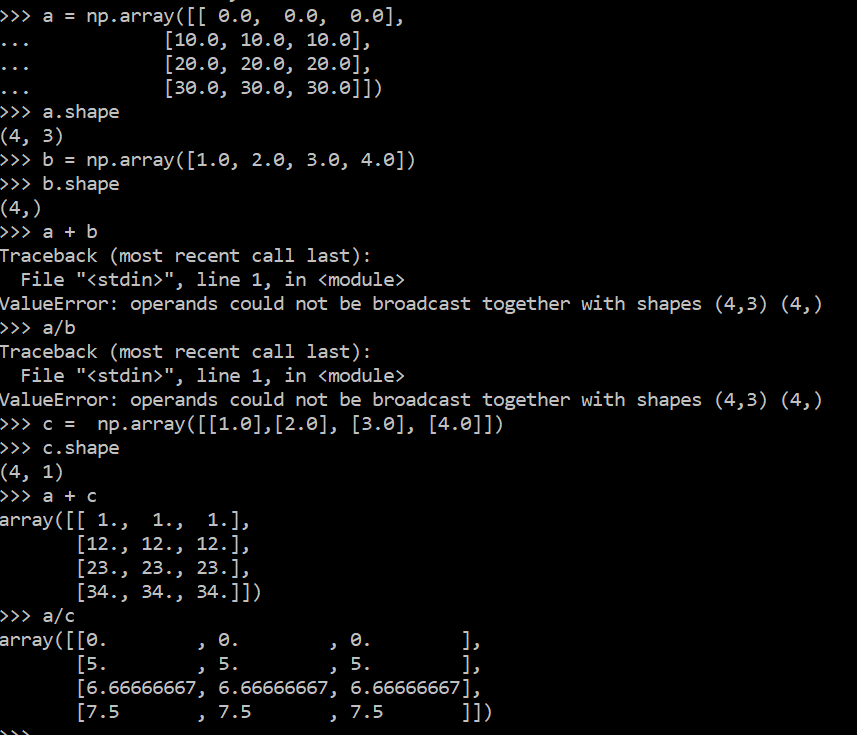

In [36]:
#y_hat_tmp = exp_logits / np.sum(exp_logits, axis=1, keepdims = False) # Throws error
y_hat_tmp = exp_logits / np.sum(exp_logits, axis=1, keepdims = True) # Works
y_hat_tmp

array([[0.49427016, 0.50572984],
       [0.49894832, 0.50105168],
       [0.49983896, 0.50016104],
       ...,
       [0.49783503, 0.50216497],
       [0.49881843, 0.50118157],
       [0.50098813, 0.49901187]])

###  3. Compare the predictions $\hat{y}$ (ex.  [0.3, 0.3, 0.4]) with the actual target values $y$ (ex. class 2 would look like [0, 0, 1]) with the objective (cost) function to determine loss $J$. A common objective function for logistics regression is cross-entropy loss. 

  * $J(\theta) = - \sum_i ln(\hat{y_i}) = - \sum_i ln (\frac{e^{X_iW_y}}{\sum_j e^{X_iW}}) $

  > Note $ \hat{y} = softmax(z) = softmax(XW) = \frac{e^{XW_y}}{\sum_j e^{XW}} $

In [37]:
# Loss (J)
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train_encoded]) # We are taking the predicted probability as per the true label
loss = np.sum(correct_class_logprobs) / len(y_train) # Here, we are taking the average training loss by summing up all correct probabilities
print (f"loss: {loss:.3f}")

loss: 0.695


### 4.  Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights. Let's assume that our classes are mutually exclusive (a set of inputs could only belong to one class).

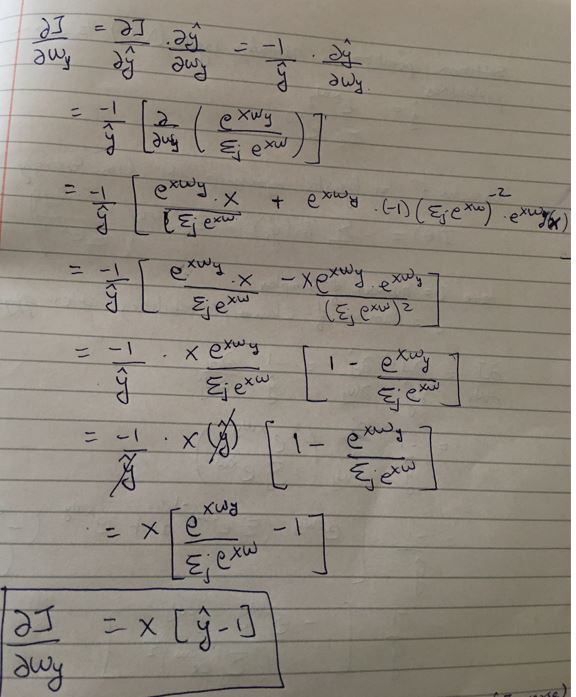

In [38]:
y_hat

array([[0.49427016, 0.50572984],
       [0.49894832, 0.50105168],
       [0.49983896, 0.50016104],
       ...,
       [0.49783503, 0.50216497],
       [0.49881843, 0.50118157],
       [0.50098813, 0.49901187]])

In [39]:
y_hat_minus_1 = y_hat # We will use this to calcualte the derivative of loss (J) wrt correct probability

In [40]:
y_hat_minus_1[range(len(y_hat)), y_train_encoded]  =  y_hat[range(len(y_hat)), y_train_encoded]  - 1    # Subsctract 1 from the correct class probability
y_hat_minus_1

array([[-0.50572984,  0.50572984],
       [-0.50105168,  0.50105168],
       [ 0.49983896, -0.49983896],
       ...,
       [ 0.49783503, -0.49783503],
       [-0.50118157,  0.50118157],
       [ 0.50098813, -0.50098813]])

In [41]:
y_hat_minus_1 /= len(y_train_encoded) # Normalize the values
y_hat_minus_1

array([[-0.00067431,  0.00067431],
       [-0.00066807,  0.00066807],
       [ 0.00066645, -0.00066645],
       ...,
       [ 0.00066378, -0.00066378],
       [-0.00066824,  0.00066824],
       [ 0.00066798, -0.00066798]])

In [42]:
# Backpropogation
dW = np.dot(X_train.T, y_hat_minus_1)
db = np.sum(y_hat_minus_1, axis=0, keepdims=True)

### 5. Update the weights $ W $  using a small learning rate $ \alpha $. The updates will penalize the probability for the incorrect classes (j) and encourage a higher probability for the correct class (y).
  * $W_j = W_j - \alpha\frac{\partial{J}}{\partial{W_j}}$

In [43]:
# Weight Update
alpha = 0.005 # learning rate

W -= alpha * dW
b -= alpha * db

##Training
(Repeat steps 2-5 for 100 Epochs)

In [44]:
EPOCHS = 200
alpha = 0.005 # learning rate

In [45]:
# Initialize random weights
W = 0.005 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES)) # Bias is initialized with 0

In [46]:
for epoch in range(1, EPOCHS +1):
  #print("Pass", epoch + 1)
  # Forward Pass
  logits = np.dot(X_train, W) + b # Calculating XW for 2 classes ("malignant", "benign")

  # Normalization via softmax to obtain class probabilities
  exp_logits = np.exp(logits)
  y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True) # y_hat contains the probabilities for both classes with shape (N,2)

  # Loss
  correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train_encoded])
  loss = np.sum(correct_class_logprobs) / len(y_train) 
  #print("Loss for Epoch {} is {}".format(epoch,loss))

  # show progress
  if epoch  % 10 == 0:

    # Accuracy
    y_pred = np.argmax(logits, axis=1) # Argmax gives the position of class wrt Logit (XW) calculations
    accuracy =  np.mean(np.equal(y_train_encoded, y_pred))
    print (f'Epoch: {epoch}, loss: {loss:.3f}, accuracy: {accuracy:.3f}')

  y_hat_minus_1 = y_hat # We will use this to calcualte the derivative of loss (J) wrt correct probability
  y_hat_minus_1[range(len(y_hat)), y_train_encoded]  =  y_hat[range(len(y_hat)), y_train_encoded]  - 1    # Subsctract 1 from the probability of correct class 
  y_hat_minus_1 /= len(y_train_encoded) # Normalize the values

  # Backpropogation
  dW = np.dot(X_train.T, y_hat_minus_1)
  db = np.sum(y_hat_minus_1, axis=0, keepdims=True)  

  # Weight Update
  W -= alpha * dW
  b -= alpha * db

Epoch: 10, loss: 0.674, accuracy: 0.912
Epoch: 20, loss: 0.656, accuracy: 0.941
Epoch: 30, loss: 0.639, accuracy: 0.952
Epoch: 40, loss: 0.623, accuracy: 0.956
Epoch: 50, loss: 0.608, accuracy: 0.957
Epoch: 60, loss: 0.594, accuracy: 0.959
Epoch: 70, loss: 0.581, accuracy: 0.961
Epoch: 80, loss: 0.568, accuracy: 0.967
Epoch: 90, loss: 0.556, accuracy: 0.967
Epoch: 100, loss: 0.544, accuracy: 0.967
Epoch: 110, loss: 0.533, accuracy: 0.967
Epoch: 120, loss: 0.523, accuracy: 0.967
Epoch: 130, loss: 0.513, accuracy: 0.969
Epoch: 140, loss: 0.503, accuracy: 0.969
Epoch: 150, loss: 0.494, accuracy: 0.969
Epoch: 160, loss: 0.486, accuracy: 0.969
Epoch: 170, loss: 0.477, accuracy: 0.969
Epoch: 180, loss: 0.469, accuracy: 0.969
Epoch: 190, loss: 0.462, accuracy: 0.969
Epoch: 200, loss: 0.455, accuracy: 0.969


## Evaluation

In [47]:
class LogisticRegressionFromScratch:
  def predict(self,x):
    logits = np.dot(x,W) + b
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return y_hat

In [48]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)


In [49]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train_encoded, pred_train))
test_acc = np.mean(np.equal(y_test_encoded, pred_test))
print (f"train acc: {train_acc:.3f}, test acc: {test_acc:.3f}")

train acc: 0.969, test acc: 0.960
